# PyTorch - Autograd (is what we need.)

Advanced Learning 2025





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 345801963
~~~

~~~
STUDENT GIT LINK: https://github.com/DanAbergel/Adv.-computational-learning-and-data-analysis/tree/main/HW1/PS1_Part3_Autograd_2025_ID_345801963.ipynb
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2025_ID_[000000000].html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [1]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cpu!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [3]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+	\beta_1\text{housing_median_age}_i+ 	\beta_2\text{total_rooms}_i+ 	\beta_3\text{total_bedrooms}_i+ 	\beta_4\text{population}_i+ 	\beta_5\text{households}_i+ 	\beta_6\text{median_income}_i 	$$

**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [4]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [5]:
#### SOLUTION REQUIRED ####
t1 = time.time()

weights_rounded = np.linalg.inv(X.T @ X) @ (X.T @ Y) # FILL IN THE MISSING CODE
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.002
The estimated weights using the analytic solution:
 [-0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

/var/folders/t8/ffgjly3d0c90vfldr57f29q00000gn/T/ipykernel_2515/1668682842.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


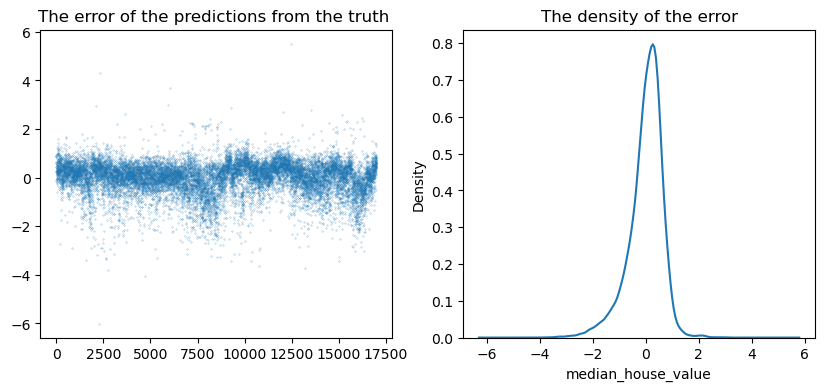

In [6]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      





In [7]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.randn() # FILL IN THE MISSING CODE
b1 = np.random.randn() # FILL IN THE MISSING CODE
b2 = np.random.randn() # FILL IN THE MISSING CODE
b3 = np.random.randn() # FILL IN THE MISSING CODE
b4 = np.random.randn() # FILL IN THE MISSING CODE
b5 = np.random.randn() # FILL IN THE MISSING CODE
b6 = np.random.randn() # FILL IN THE MISSING CODE

# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 1e-4 # FILL IN THE MISSING CODE

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    Y_pred =  b0*X[:,0] + b1*X[:,1] + b2*X[:,2] + b3*X[:,3] + b4*X[:,4] + b5*X[:,5] + b6*X[:,6] # FILL IN THE MISSING CODE

    # Compute and print loss
    loss = np.mean((Y_pred - Y)**2) # FILL IN THE MISSING CODE
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2 * (Y_pred - Y) / len(Y) # FILL IN THE MISSING CODE
    grad_b0 = np.sum(grad_y_pred * X[:,0])
    grad_b1 = np.sum(grad_y_pred * X[:,1])
    grad_b2 = np.sum(grad_y_pred * X[:,2])
    grad_b3 = np.sum(grad_y_pred * X[:,3])
    grad_b4 = np.sum(grad_y_pred * X[:,4])
    grad_b5 = np.sum(grad_y_pred * X[:,5])
    grad_b6 = np.sum(grad_y_pred * X[:,6])


    # Update weights
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    b4 -= learning_rate * grad_b4
    b5 -= learning_rate * grad_b5
    b6 -= learning_rate * grad_b6

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:1.7922023934336346
Epoch:1000, loss:1.2954420103924316
Epoch:2000, loss:1.0146479512712292
Epoch:3000, loss:0.8374922451102249
Epoch:4000, loss:0.720813208347941
Result: y_hat = 0.0618342647617221 x0 + 0.12201631500721138 x1 + -0.4969205911446931 x2 + 1.494899893787282 x3
 + -0.5567870771151914 x4 + -0.38660511831805344 x5 + 0.4447113137105813 x6 

Total process time: 1.937
The estimated weights using the gradient descent solution:
 [ 0.062  0.122 -0.497  1.495 -0.557 -0.387  0.445]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [10]:
# Creating data and target tensors:
tX = torch.tensor(X, dtype=torch.float32)
tY = torch.tensor(Y, dtype=torch.float32)

t3 = time.time()

# Randomly initialize weights using PyTorch (without autograd since manual gradient)
tb0 = torch.randn(())
tb1 = torch.randn(())
tb2 = torch.randn(())
tb3 = torch.randn(())
tb4 = torch.randn(())
tb5 = torch.randn(())
tb6 = torch.randn(())

# Set learning rate
learning_rate = 1e-4

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = (tb0*tX[:,0] + tb1*tX[:,1] + tb2*tX[:,2] +
               tb3*tX[:,3] + tb4*tX[:,4] + tb5*tX[:,5] + tb6*tX[:,6])

    # Compute and print loss (MSE)
    loss = torch.mean((tY_pred - tY)**2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2 * (tY_pred - tY) / tY.shape[0]

    grad_b0 = torch.sum(grad_y_pred * tX[:,0])
    grad_b1 = torch.sum(grad_y_pred * tX[:,1])
    grad_b2 = torch.sum(grad_y_pred * tX[:,2])
    grad_b3 = torch.sum(grad_y_pred * tX[:,3])
    grad_b4 = torch.sum(grad_y_pred * tX[:,4])
    grad_b5 = torch.sum(grad_y_pred * tX[:,5])
    grad_b6 = torch.sum(grad_y_pred * tX[:,6])

    # Update weights
    tb0 -= learning_rate * grad_b0
    tb1 -= learning_rate * grad_b1
    tb2 -= learning_rate * grad_b2
    tb3 -= learning_rate * grad_b3
    tb4 -= learning_rate * grad_b4
    tb5 -= learning_rate * grad_b5
    tb6 -= learning_rate * grad_b6

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:3.646738290786743
epoch:1000, loss:2.3279521465301514
epoch:2000, loss:1.7065659761428833
epoch:3000, loss:1.3418550491333008
epoch:4000, loss:1.1052073240280151
Result: y_hat = -0.5227428078651428 x0 + 0.4587928354740143 x1 + 0.9590994715690613 x2 + -0.34754762053489685 x3
 + -1.0976204872131348 x4 + 0.6818938851356506 x5 + 0.5783899426460266 x6 

Total process time: 0.993
The estimated weights using the gradient descent on tensors:
 [-0.523  0.459  0.959 -0.348 -1.098  0.682  0.578]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [11]:
t4 = time.time()

# 1x7 weight vector with gradient tracking
tb = torch.randn(7, requires_grad=True)

# Learning rate
learning_rate = 1e-4
epochs = int(5e3)

for t in range(epochs):

    # Forward pass
    tY_pred = tX @ tb        # matrix-vector multiplication

    # Loss = MSE
    loss = torch.mean((tY_pred - tY)**2)

    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop (autograd computes the gradients for us)
    loss.backward()

    with torch.no_grad():       # Update weights without tracking the update
        tb -= learning_rate * tb.grad
        tb.grad = None          # Clear gradients

print(f"\nResult: betas = {tb}")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.detach().numpy()
print(f"The estimated weights using the PyTorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:4.365835189819336
epoch:1000, loss:3.009922981262207
epoch:2000, loss:2.1428470611572266
epoch:3000, loss:1.5779869556427002
epoch:4000, loss:1.207412600517273

Result: betas = tensor([-0.2034,  0.2782,  0.3307,  0.3507, -0.4406, -0.0804,  0.0038],
       requires_grad=True)
Total process time: 0.448
The estimated weights using the PyTorch autograd:
 [-0.203  0.278  0.331  0.351 -0.441 -0.08   0.004]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1.	The analytic solution is the most accurate because it directly computes the weights that minimize the mean squared error. However, it is not always applicable. If X^TX is not invertible (for example because of multicollinearity), or if the dataset is very large, we cannot reliably or efficiently compute the inverse. In those cases, we use gradient-based methods instead.
	2.	We scaled the data so that all features are on similar ranges. This helps the optimization algorithm converge faster and prevents some weights from becoming too large just because the input values have larger magnitudes. It also improves numerical stability.
	3.	The model works well only if the relationship between the inputs and the target is approximately linear. If the loss is low and the learned weights are consistent between methods, then the model specification is likely reasonable. If the loss stays high, then the model is probably missing important nonlinear effects or interactions.
	4.	The analytic solution is fast for small datasets because it solves the problem in one step. Gradient descent takes longer because it updates the weights over many iterations. But for very large datasets, the analytic solution becomes slow or impractical, and gradient descent scales better.
	5.	To improve the model, we could add interaction terms or polynomial features to capture nonlinear relationships. We could also apply regularization (such as Ridge or Lasso) to improve generalization and avoid large coefficients.
	6.	To improve the solution algorithm, we can use PyTorch’s built-in tools (nn.Linear and torch.optim) and possibly mini-batch gradient descent. We can also try different optimizers like Adam, which often converges faster and more smoothly than plain gradient descent.